# RNA Test Features Extraction

This notebook extracts features for RNA test data that does NOT include 3D structural information.
Only the following features can be extracted for test data:
1. Thermodynamic features from RNA sequences
2. Mutual Information features from Multiple Sequence Alignments (MSAs)

Note: Pseudodihedral angle features cannot be generated for test data since this requires 3D coordinates.

## Dependencies
- ViennaRNA (for thermodynamic features)
- NumPy/SciPy/Pandas (core data processing)
- Memory monitoring tools from src.analysis.memory_monitor
- Feature extraction functions from src.analysis modules

In [1]:
# Standard imports
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import time
import json
import psutil

# Ensure the parent directory is in the path so we can import our modules
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import feature extraction modules
from src.analysis.thermodynamic_analysis import extract_thermodynamic_features
from src.analysis.dihedral_analysis import extract_dihedral_features
from src.analysis.mutual_information import calculate_mutual_information, convert_mi_to_evolutionary_features
from src.data.extract_features_simple import save_features_npz

# Import memory monitoring utilities
from src.analysis.memory_monitor import MemoryTracker, log_memory_usage, plot_memory_usage

ViennaRNA module imported successfully (version: 2.6.4)


# Configuration

# Define paths and parameters for feature extraction.

In [2]:
# Define relative paths
DATA_DIR = Path("../data")
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
# Output directories for each feature type
THERMO_DIR = PROCESSED_DIR / "thermo_features"
DIHEDRAL_DIR = PROCESSED_DIR / "dihedral_features"
MI_DIR = PROCESSED_DIR / "mi_features"
MEMORY_PLOTS_DIR = PROCESSED_DIR / "memory_plots"

# Make sure all directories exist
for directory in [RAW_DIR, PROCESSED_DIR, THERMO_DIR, DIHEDRAL_DIR, MI_DIR, MEMORY_PLOTS_DIR]:
            directory.mkdir(exist_ok=True, parents=True)
            
# Parameters
LIMIT = 5  # Limit for testing; set to None to process all data
VERBOSE = True  # Whether to print detailed progress

# Auto-detect if running on Kaggle
KAGGLE_MODE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE') is not None
if KAGGLE_MODE:
        print("Running in Kaggle environment")

# Helper Functions

# Define utility functions for loading data and extracting features.

In [3]:
def load_rna_data(csv_path):
    """
    Load RNA data from CSV file.
    
    Args:
        csv_path: Path to CSV file containing RNA data
        
    Returns:
        DataFrame with RNA data
    """
    try:
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} entries from {csv_path}")
        return df
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return None

def get_unique_target_ids(df, id_col="ID"):
    """
    Extract unique target IDs from dataframe.
    
    Args:
        df: DataFrame with RNA data
        id_col: Column containing IDs
        
    Returns:
        List of unique target IDs
    """
    # Extract target IDs (format: TARGET_ID_RESIDUE_NUM)
    target_ids = []
    for id_str in df[id_col]:
        # Split the ID string and get the target ID part
        parts = id_str.split('_')
        if len(parts) >= 2:
            target_id = f"{parts[0]}_{parts[1]}"  # Take the first two parts (e.g., "1SCL_A")
            target_ids.append(target_id)
    
    # Get unique target IDs
    unique_targets = sorted(list(set(target_ids)))
    print(f"Found {len(unique_targets)} unique target IDs")
    return unique_targets

def load_msa_data(target_id, data_dir=RAW_DIR):
    """
    Load MSA data for a given target.
    
    Args:
        target_id: Target ID
        data_dir: Directory containing MSA data
        
    Returns:
        List of MSA sequences or None if not found
    """
    # Define possible MSA directories and extensions
    msa_dirs = [
        data_dir / "MSA",
        data_dir,
        data_dir / "alignments",
        data_dir / "test" / "MSA",
        data_dir / "test",
        data_dir / "test" / "alignments"
    ]
    
    extensions = [".MSA.fasta", ".fasta", ".fa", ".afa", ".msa"]
    
    # Try all combinations of directories and extensions
    for msa_dir in msa_dirs:
        if not msa_dir.exists():
            continue
            
        for ext in extensions:
            msa_path = msa_dir / f"{target_id}{ext}"
            if msa_path.exists():
                print(f"Loading MSA data from {msa_path}")
                try:
                    # Parse FASTA file
                    sequences = []
                    current_seq = ""
                    
                    with open(msa_path, 'r') as f:
                        for line in f:
                            line = line.strip()
                            if line.startswith('>'):
                                if current_seq:
                                    sequences.append(current_seq)
                                    current_seq = ""
                            else:
                                current_seq += line
                                
                        # Add the last sequence
                        if current_seq:
                            sequences.append(current_seq)
                    
                    print(f"Loaded {len(sequences)} sequences from MSA")
                    return sequences
                except Exception as e:
                    print(f"Error loading MSA data: {e}")
    
    # Fallback: try recursive search
    print(f"MSA file not found in standard locations, trying recursive search...")
    try:
        for msa_dir in [data_dir, data_dir / "test"]:
            if not msa_dir.exists():
                continue
                
            for ext in extensions:
                pattern = f"**/{target_id}{ext}"
                matches = list(msa_dir.glob(pattern))
                if matches:
                    msa_path = matches[0]
                    print(f"Found MSA via recursive search: {msa_path}")
                    
                    # Parse the file
                    sequences = []
                    current_seq = ""
                    
                    with open(msa_path, 'r') as f:
                        for line in f:
                            line = line.strip()
                            if line.startswith('>'):
                                if current_seq:
                                    sequences.append(current_seq)
                                    current_seq = ""
                            else:
                                current_seq += line
                                
                        # Add the last sequence
                        if current_seq:
                            sequences.append(current_seq)
                    
                    print(f"Loaded {len(sequences)} sequences from MSA")
                    return sequences
    except Exception as e:
        print(f"Error in recursive MSA search: {e}")
    
    print(f"Could not find MSA data for {target_id}")
    return None

def get_sequence_for_target(target_id, data_dir=RAW_DIR):
    """
    Get RNA sequence for a target ID from the sequence file.
    
    Args:
        target_id: Target ID
        data_dir: Directory containing sequence data
        
    Returns:
        RNA sequence as string or None if not found
    """
    # Try different possible file locations
    sequence_paths = [
        data_dir / "test" / "sequences.csv",
        data_dir / "test" / "test_sequences.csv",
        data_dir / "test" / "rna_sequences.csv",
        data_dir / "test_sequences.csv",
        data_dir / "sequences.csv"
    ]
    
    for path in sequence_paths:
        if path.exists():
            try:
                df = pd.read_csv(path)
                
                # Try different possible column names
                id_cols = ["target_id", "ID", "id"]
                seq_cols = ["sequence", "Sequence", "seq"]
                
                for id_col in id_cols:
                    if id_col in df.columns:
                        for seq_col in seq_cols:
                            if seq_col in df.columns:
                                # Find the target in the dataframe
                                target_row = df[df[id_col] == target_id]
                                if len(target_row) > 0:
                                    sequence = target_row[seq_col].iloc[0]
                                    return sequence
            except Exception as e:
                print(f"Error loading sequence data from {path}: {e}")
    
    # If we still haven't found the sequence, try to extract it from MSA data
    msa_sequences = load_msa_data(target_id, data_dir)
    if msa_sequences and len(msa_sequences) > 0:
        # The first sequence in the MSA is typically the target sequence
        return msa_sequences[0]
    
    print(f"Could not find sequence for {target_id}")
    return None

## Feature Extraction Functions

Define functions for extracting each type of feature.

In [4]:
def extract_thermo_features_for_target(target_id, sequence=None):
    """
    Extract thermodynamic features for a given target.
    
    Args:
        target_id: Target ID
        sequence: RNA sequence (optional, will be loaded if not provided)
        
    Returns:
        Dictionary with thermodynamic features or None if failed
    """
    print(f"Extracting thermodynamic features for {target_id}")
    start_time = time.time()
    
    try:
        # Get sequence if not provided
        if sequence is None:
            sequence = get_sequence_for_target(target_id)
            if sequence is None:
                print(f"Failed to get sequence for {target_id}")
                return None
        
        # Log initial memory usage
        log_memory_usage(f"Before thermo features for {target_id} (len={len(sequence)})")
        
        # Calculate features with memory monitoring
        print(f"Calculating thermodynamic features for sequence of length {len(sequence)}")
        with MemoryTracker(f"Thermodynamic features calculation for {target_id}"):
            features = extract_thermodynamic_features(sequence)
        
        # Save features
        output_file = THERMO_DIR / f"{target_id}_thermo_features.npz"
        features['target_id'] = target_id
        features['sequence'] = sequence
        
        with MemoryTracker("Saving thermodynamic features"):
            save_features_npz(features, output_file)
        
        # Log final memory usage
        log_memory_usage(f"After thermo features for {target_id}")
        
        elapsed_time = time.time() - start_time
        print(f"Extracted thermodynamic features in {elapsed_time:.2f} seconds")
        return features
    
    except Exception as e:
        print(f"Error extracting thermodynamic features for {target_id}: {e}")
        import traceback
        traceback.print_exc()
        return None

def extract_mi_features_for_target(target_id, msa_sequences=None):
    """
    Extract Mutual Information features for a given target.
    
    Args:
        target_id: Target ID
        msa_sequences: List of MSA sequences (optional, will be loaded if not provided)
        
    Returns:
        Dictionary with MI features or None if failed
    """
    print(f"Extracting MI features for {target_id}")
    start_time = time.time()
    
    try:
        # Get MSA sequences if not provided
        if msa_sequences is None:
            msa_sequences = load_msa_data(target_id)
            if msa_sequences is None or len(msa_sequences) < 2:
                print(f"Failed to get MSA data for {target_id} or not enough sequences")
                return None
        
        # Log memory before MI calculation
        sequence_length = len(msa_sequences[0]) if msa_sequences else 0
        msa_size = len(msa_sequences) if msa_sequences else 0
        log_memory_usage(f"Before MI features for {target_id} (seq_len={sequence_length}, msa_size={msa_size})")
        
        # Calculate MI (this may take some time for large MSAs)
        print(f"Calculating MI for {len(msa_sequences)} sequences")
        with MemoryTracker(f"MI calculation for {target_id}"):
            mi_result = calculate_mutual_information(msa_sequences, verbose=VERBOSE)
        
        if mi_result is None:
            print(f"Failed to calculate MI for {target_id}")
            return None
        
        # Convert to evolutionary features
        output_file = MI_DIR / f"{target_id}_mi_features.npz"
        features = mi_result
        
        # Save features
        with MemoryTracker(f"Saving MI features for {target_id}"):
            np.savez_compressed(output_file, **features)
        print(f"Saved MI features to {output_file}")
        
        # Log memory after MI calculation
        log_memory_usage(f"After MI features for {target_id}")
        
        elapsed_time = time.time() - start_time
        print(f"Extracted MI features in {elapsed_time:.2f} seconds")
        
        # Add target ID
        features['target_id'] = target_id
        return features
    
    except Exception as e:
        print(f"Error extracting MI features for {target_id}: {e}")
        import traceback
        traceback.print_exc()
        return None

## Batch Processing

Process multiple targets in batch mode.

In [5]:
def process_target(target_id, extract_thermo=True, extract_mi=True):
    """
    Process a single target, extracting all requested feature types.
    
    Args:
        target_id: Target ID
        extract_thermo: Whether to extract thermodynamic features
        extract_mi: Whether to extract MI features
        
    Returns:
        Dictionary with results for each feature type
    """
    print(f"\nProcessing target: {target_id}")
    results = {'target_id': target_id}
    start_time = time.time()
    
    # Load common data that might be used by multiple feature types
    sequence = get_sequence_for_target(target_id) if extract_thermo else None
    msa_sequences = load_msa_data(target_id) if extract_mi else None
    
    # Extract thermodynamic features
    if extract_thermo:
        thermo_file = THERMO_DIR / f"{target_id}_thermo_features.npz"
        
        if thermo_file.exists():
            print(f"Thermodynamic features already exist for {target_id}")
            results['thermo'] = {'success': True, 'skipped': True}
        else:
            thermo_features = extract_thermo_features_for_target(target_id, sequence)
            results['thermo'] = {'success': thermo_features is not None}
    
    # Extract MI features
    if extract_mi:
        mi_file = MI_DIR / f"{target_id}_mi_features.npz"
        
        if mi_file.exists():
            print(f"MI features already exist for {target_id}")
            results['mi'] = {'success': True, 'skipped': True}
        else:
            mi_features = extract_mi_features_for_target(target_id, msa_sequences)
            results['mi'] = {'success': mi_features is not None}
    
    # Calculate total time
    elapsed_time = time.time() - start_time
    results['elapsed_time'] = elapsed_time
    print(f"Completed processing {target_id} in {elapsed_time:.2f} seconds")
    
    return results

def batch_process_targets(target_ids, extract_thermo=True, extract_mi=True):
    """
    Process multiple targets in batch mode.
    
    Args:
        target_ids: List of target IDs
        extract_thermo: Whether to extract thermodynamic features
        extract_mi: Whether to extract MI features
        
    Returns:
        Dictionary with results for each target
    """
    print(f"Starting batch processing for {len(target_ids)} targets")
    start_time = time.time()
    
    results = {}
    for i, target_id in enumerate(target_ids):
        print(f"\nProcessing target {i+1}/{len(target_ids)}: {target_id}")
        
        # Process the target
        target_results = process_target(
            target_id, 
            extract_thermo=extract_thermo, 
            extract_mi=extract_mi
        )
        
        # Store results
        results[target_id] = target_results
    
    # Calculate statistics
    total_time = time.time() - start_time
    
    success_counts = {
        'thermo': sum(1 for r in results.values() if 'thermo' in r and r['thermo']['success']),
        'mi': sum(1 for r in results.values() if 'mi' in r and r['mi']['success'])
    }
    
    skipped_counts = {
        'thermo': sum(1 for r in results.values() if 'thermo' in r and r['thermo'].get('skipped', False)),
        'mi': sum(1 for r in results.values() if 'mi' in r and r['mi'].get('skipped', False))
    }
    
    # Print summary
    print("\nBatch processing complete!")
    print(f"Total targets: {len(target_ids)}")
    print(f"Total time: {total_time:.2f} seconds")
    
    if extract_thermo:
        print(f"Thermodynamic features: {success_counts['thermo']} successful ({skipped_counts['thermo']} skipped)")
        
    if extract_mi:
        print(f"MI features: {success_counts['mi']} successful ({skipped_counts['mi']} skipped)")
    
    # Save summary
    summary = {
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
        'total_targets': len(target_ids),
        'total_time': total_time,
        'success_counts': success_counts,
        'skipped_counts': skipped_counts,
        'target_results': results
    }
    
    with open(PROCESSED_DIR / 'test_processing_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    
    return results

## Load Test Data

In [10]:
# Load test data file or try to find test labels file
test_paths = [
    RAW_DIR / "test_sequences.csv",
    RAW_DIR / "test" / "sequences.csv"
]

test_data = None
for test_file in test_paths:
    if test_file.exists():
        test_data = load_rna_data(test_file)
        if test_data is not None:
            break

if test_data is None:
    print("Error loading test data. Please make sure at least one test file exists.")

Loaded 12 entries from ../data/raw/test_sequences.csv


## Extract Unique Target IDs

In [11]:
# Get unique target IDs
if test_data is not None and not test_data.empty:
    # Look for ID column
    id_col = None
    for col_name in ["target_id", "ID", "id"]:
        if col_name in test_data.columns:
            id_col = col_name
            break
    
    if id_col is None:
        print("Error: Could not find ID column in test data")
        target_ids = []
    else:
        # For test data, the IDs might already be unique without residue numbers
        # Check if IDs contain underscore
        if any("_" in str(id_val) for id_val in test_data[id_col]):
            target_ids = get_unique_target_ids(test_data, id_col=id_col)
        else:
            # IDs are already unique targets
            target_ids = test_data[id_col].unique().tolist()
            print(f"Found {len(target_ids)} unique target IDs")
    
    # Limit for testing
    if LIMIT is not None and LIMIT < len(target_ids):
        print(f"Limiting to first {LIMIT} targets for testing")
        target_ids = target_ids[:LIMIT]
else:
    print("No test data available. Please check your test data files.")
    target_ids = []

Found 12 unique target IDs
Limiting to first 5 targets for testing


## Process Targets

In [12]:
if target_ids:
    # Process targets
    results = batch_process_targets(
        target_ids,
        extract_thermo=True,
        extract_mi=True
    )
    
    # Verify features
    print("\nVerifying processed features for compatibility...")
    import subprocess
    import sys
    
    verification_script = Path("../scripts/verify_feature_compatibility.py")
    if verification_script.exists():
        try:
            # Run the script as a subprocess
            cmd = [sys.executable, str(verification_script), str(PROCESSED_DIR), "--verbose"]
            result = subprocess.run(cmd, capture_output=True, text=True)
            
            # Print the output
            print(result.stdout)
            
            # Check for errors
            if result.returncode != 0:
                print(f"Verification failed with exit code {result.returncode}")
                if result.stderr:
                    print(f"Error output: {result.stderr}")
        except Exception as e:
            print(f"Error running verification script: {e}")
    else:
        print(f"Warning: Feature verification script not found at {verification_script}")
        
else:
    print("No targets to process. Please check your test data file.")

Starting batch processing for 5 targets

Processing target 1/5: R1107

Processing target: R1107
Loading MSA data from ../data/raw/MSA/R1107.MSA.fasta
Loaded 1810 sequences from MSA
Thermodynamic features already exist for R1107
MI features already exist for R1107
Completed processing R1107 in 0.00 seconds

Processing target 2/5: R1108

Processing target: R1108
Loading MSA data from ../data/raw/MSA/R1108.MSA.fasta
Loaded 3183 sequences from MSA
Thermodynamic features already exist for R1108
MI features already exist for R1108
Completed processing R1108 in 0.00 seconds

Processing target 3/5: R1116

Processing target: R1116
Loading MSA data from ../data/raw/MSA/R1116.MSA.fasta
Loaded 2021 sequences from MSA
Thermodynamic features already exist for R1116
MI features already exist for R1116
Completed processing R1116 in 0.00 seconds

Processing target 4/5: R1117v2

Processing target: R1117v2
Loading MSA data from ../data/raw/MSA/R1117v2.MSA.fasta
Loaded 192 sequences from MSA
Thermodynamic

## Visualization and Validation

Visualize and validate the features.

Visualizing features for example target: R1107
Available feature types: ['thermo', 'mi']

Thermodynamic features:
  mfe: -21.600000381469727
  ensemble_energy: -21.590000381469725
  prob_of_mfe: 0.03317093058302927
  mean_entropy: 1.906566868590242


AttributeError: 'CompositeGenericTransform' object has no attribute 'skewed'

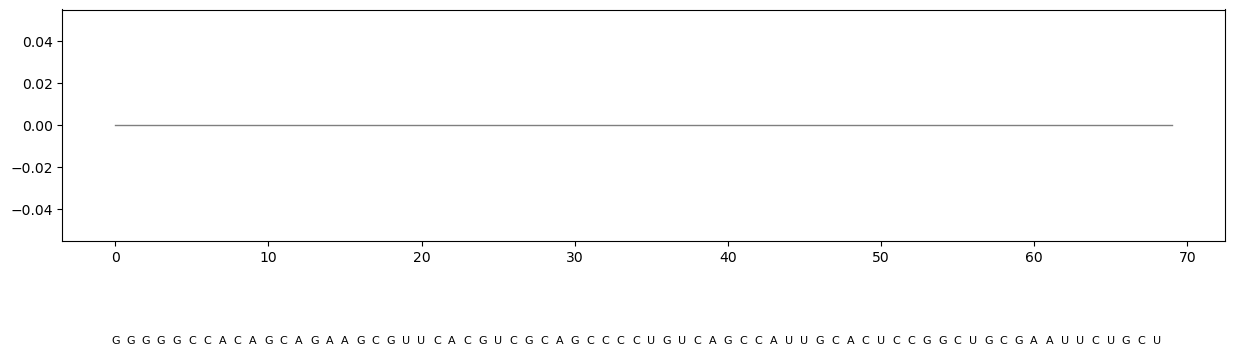

In [13]:
# Function to load features for a target
def load_features(target_id):
    """
    Load features for a target ID.
    
    Args:
        target_id: Target ID
        
    Returns:
        Dictionary with features from all three types
    """
    features = {}
    
    # Load thermodynamic features
    thermo_file = THERMO_DIR / f"{target_id}_thermo_features.npz"
    if thermo_file.exists():
        features['thermo'] = dict(np.load(thermo_file, allow_pickle=True))
    
    # Load MI features
    mi_file = MI_DIR / f"{target_id}_mi_features.npz"
    if mi_file.exists():
        features['mi'] = dict(np.load(mi_file, allow_pickle=True))
    
    return features

# Select a target for visualization
if target_ids and len(target_ids) > 0:
    example_target = target_ids[0]
    print(f"Visualizing features for example target: {example_target}")
    
    # Load features
    features = load_features(example_target)
    
    # Print available feature types
    print(f"Available feature types: {list(features.keys())}")
    
    # Visualize thermodynamic features if available
    if 'thermo' in features:
        thermo = features['thermo']
        print("\nThermodynamic features:")
        
        # Print basic features
        for key in ['mfe', 'ensemble_energy', 'prob_of_mfe', 'mean_entropy']:
            if key in thermo:
                print(f"  {key}: {thermo[key]}")
        
        # Plot structure diagram if available
        if 'structure' in thermo and 'sequence' in thermo:
            sequence = str(thermo['sequence'])
            structure = str(thermo['structure'])
            
            # Create a simple visualization of the structure
            fig, ax = plt.subplots(figsize=(15, 3))
            
            # Plot paired bases as arcs
            stack = []
            pairs = []
            for i, char in enumerate(structure):
                if char == '(':
                    stack.append(i)
                elif char == ')':
                    if stack:
                        j = stack.pop()
                        pairs.append((j, i))
            
            # Draw baselines
            ax.plot([0, len(structure)], [0, 0], 'k-', lw=1, alpha=0.5)
            
            # Draw nucleotides
            for i, base in enumerate(sequence):
                ax.text(i, -0.1, base, ha='center', va='top', fontsize=8)
            
            # Draw arcs
            for i, j in pairs:
                center = (i + j) / 2
                width = abs(j - i)
                height = width / 5  # Adjust for aesthetics
                ax.add_patch(plt.Rectangle((center - width/2, 0), width, height, 
                             facecolor='none', edgecolor='blue', alpha=0.5, 
                             transform=ax.transData.skewed(0, 0, 1, 0)))
            
            ax.set_title(f"RNA Structure for {example_target}")
            ax.set_xlim(-1, len(structure) + 1)
            ax.set_ylim(-0.5, (len(structure)/10) + 1)
            ax.set_yticks([])
            ax.set_xticks(range(0, len(structure), 10))
            plt.show()
        
        # Plot positional entropy if available
        if 'position_entropy' in thermo:
            entropy = thermo['position_entropy']
            
            plt.figure(figsize=(12, 4))
            plt.plot(range(len(entropy)), entropy, 'b-')
            plt.title(f"Positional Entropy for {example_target}")
            plt.xlabel("Position")
            plt.ylabel("Entropy")
            plt.grid(alpha=0.3)
            plt.show()
    
    # Visualize MI features if available
    if 'mi' in features:
        mi = features['mi']
        print("\nMI features:")
        
        # Print top pairs if available
        if 'top_pairs' in mi and len(mi['top_pairs']) > 0:
            top_pairs = mi['top_pairs']
            print(f"  Top 5 MI pairs:")
            for i in range(min(5, len(top_pairs))):
                pair = top_pairs[i]
                print(f"    {pair[0]} - {pair[1]}: {pair[2]:.4f}")
        
        # Plot MI matrix if available
        if 'scores' in mi:
            scores = mi['scores']
            
            plt.figure(figsize=(10, 8))
            plt.imshow(scores, cmap='viridis', origin='lower')
            plt.colorbar(label='Mutual Information')
            plt.title(f"Mutual Information Matrix for {example_target}")
            plt.xlabel("Position")
            plt.ylabel("Position")
            plt.show()
else:
    print("No targets available for visualization")